Plan for HP test 1:

  [+] Impl LIF N_Neurons = image size
  [+] Enable feed image to neurons as input
    [+] Try PoissonGroup with non-uniform frequency
  [+] Plot spike rate as image
  [+] Impl HP
  [+] Plot spike rate and thresholds as image after cat
  [ ] Plot statistics on threshold change

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from brian2 import *

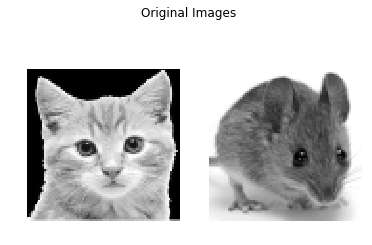

In [3]:
# Load raw images
# img1 = (mpimg.imread('img/cat4.png')[:,:,0] > 0.5).astype(int)
# img2 = (mpimg.imread('img/mouse4.png')[:,:,0] > 0.5).astype(int)
img1 = mpimg.imread('../img/cat4.png')
img2 = mpimg.imread('../img/mouse4.png')

# Plot raw images
fig, axis = plt.subplots(ncols=2)
axis[0].imshow(img1, cmap='gray')
axis[1].imshow(img2, cmap='gray')
axis[0].set_axis_off()
axis[1].set_axis_off()
plt.suptitle('Original Images')
plt.show()

Number of neurons is 6400


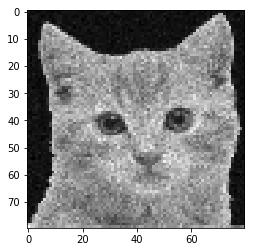

In [20]:
################################################################
# Example 1: Making Poisson neurons spike like a cat
################################################################
start_scope()
prefs.codegen.target = "numpy"

N_NEURON = img1.shape[0] * img1.shape[1]
print('Number of neurons is', N_NEURON)

RUN_TIME = 1000*ms
INPUT_BIAS = 10*Hz
INPUT_SENSITIITY = 100*Hz

# Poisson neurons have baseline spike rate, and spike rate caused by input image
P_img1 = PoissonGroup(N_NEURON, INPUT_BIAS + INPUT_SENSITIITY * np.ndarray.flatten(img1))

spikemon = SpikeMonitor(P_img1)

run(RUN_TIME)

# Compute observed spike rate by counting how many times each neuron spiked
rate = np.zeros(N_NEURON)
for i in np.array(spikemon.i):
    rate[i] += float(RUN_TIME)

# Plot observed spike rate 
plt.figure()
plt.imshow(rate.reshape(img1.shape), cmap='gray')
plt.show()

WARNING    "i" is an internal variable of group "synapses_1", but also exists in the run namespace with the value 6368. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Number of neurons is 6400


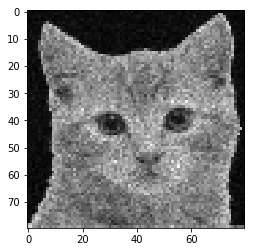

In [21]:
################################################################
# Example 2: Feeding Poisson input into LIF population
################################################################
start_scope()
prefs.codegen.target = "numpy"

N_NEURON = img1.shape[0] * img1.shape[1]
print('Number of neurons is', N_NEURON)

RUN_TIME = 1000*ms
INPUT_BIAS = 10*Hz
INPUT_SENSITIITY = 100*Hz
TAU_LEAK = 10*ms
V_THR = 0.8
V0 = 0.0
W0_INPUT = 1.0

# Define LIF neurons that spike for a fixed threshold
eqs = '''
dv/dt = (1-v) / TAU_LEAK : 1
'''

# Connect input Poisson neurons to LIF neurons one-to-one
P_img1 = PoissonGroup(N_NEURON, INPUT_BIAS + INPUT_SENSITIITY * np.ndarray.flatten(img1))
G = NeuronGroup(N_NEURON, eqs, threshold='v > V_THR', reset='v = V0', method='exact')
S = Synapses(P_img1, G, on_pre='v_post += W0_INPUT')
S.connect(j='i')

# NOTE: As opposed to Example1, here we monitor the spiking of the LIF neurons
spikemon = SpikeMonitor(G)

run(RUN_TIME)

# Compute observed spike rate by counting how many times each neuron spiked
rate = np.zeros(N_NEURON)
for i in np.array(spikemon.i):
    rate[i] += float(RUN_TIME)

# Plot observed spike rate 
plt.figure()
plt.imshow(rate.reshape(img1.shape), cmap='gray')
plt.show()

Some mathematical rules of thumb:
* Typical Firing Threshold, Presynaptic spike rate, presynaptic weight, and leaky timescale are related via $\bar{T} \approx 0.5 \tau_V f_I W_I$
* Typical Firing Threshold increase due to presynaptic spike is roughly $\Delta \bar{T} \approx \bar{T} \frac{\tau_V}{\tau_T}$, where $\tau_T$ is the typical homeostatic plasticity decay rate


WARNING    "i" is an internal variable of group "synapses", but also exists in the run namespace with the value 6374. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Number of neurons is 6400
Threshold growth per spike is 2.5 mV
Typical threshold is 50. mV , voltage increase per spike is 83.33333333 mV
Average threshold after training is 0.0325670001758


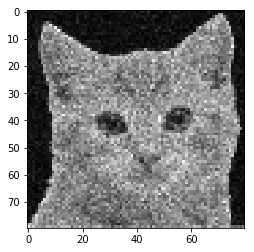

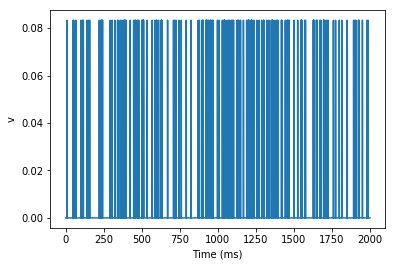

In [22]:
################################################################
# Example 3: Adapting LIF threshold based on its spike rate
################################################################
start_scope()
prefs.codegen.target = "numpy"

N_NEURON = img1.shape[0] * img1.shape[1]
print('Number of neurons is', N_NEURON)

RUN_TIME = 2000*ms

LIF_V_TAU = 10*ms
LIF_V_0 = 0.0*mV

LIF_T_TAU = 200*ms
LIF_T_0 = 1.0*mV
LIF_T_AVG = 50.0*mV
LIF_DT_PER_SPIKE = LIF_T_AVG * (LIF_V_TAU / LIF_T_TAU)
print("Threshold growth per spike is", LIF_DT_PER_SPIKE)

# Sync input voltage, so that for average threshold the leak would balance out the input
INPUT_FREQ_0 = 10*Hz
INPUT_FREQ_MAX = 100*Hz
INPUT_FREQ_AVG = INPUT_FREQ_0 + INPUT_FREQ_MAX / 2
INPUT_DV_PER_SPIKE = LIF_T_AVG / LIF_V_TAU / INPUT_FREQ_AVG
print("Typical threshold is", LIF_T_AVG, ", voltage increase per spike is", INPUT_DV_PER_SPIKE)

# Membrane potential V and threshold T both return back to resting values over time
eqs_neu = '''
dv/dt = (LIF_V_0 - v) / LIF_V_TAU : volt
dT/dt = (LIF_T_0 - T) / LIF_T_TAU : volt
'''

# On spike, the threshold is increased
reset = '''
v = LIF_V_0
T += LIF_DT_PER_SPIKE
'''

# Connect Input and LIF one-to-one
P_img1 = PoissonGroup(N_NEURON, INPUT_FREQ_0 + INPUT_FREQ_MAX * np.ndarray.flatten(img1))
G = NeuronGroup(N_NEURON, eqs_neu, threshold='v > T', reset=reset, method='exact')
S = Synapses(P_img1, G, on_pre='v_post += INPUT_DV_PER_SPIKE')
S.connect(j='i')

# Monitor the value of one neuron somewhere in the middle of the image
M = StateMonitor(G, 'v', record=3000)

run(RUN_TIME)

# Plot resulting threshold values
print("Average threshold after training is", np.average(np.array(G.T)))
plt.figure()
plt.imshow(np.array(G.T).reshape(img1.shape), cmap='gray')
plt.show()

plt.figure()
plt.plot(M.t/ms, M.v[0])
plt.xlabel('Time (ms)')
plt.ylabel('v');

Number of neurons is 6400
Typical threshold is 50. mV , voltage increase per spike is 20.83333333 mV
typical number of presynaptic neurons 64.0
typical potential change per lateral spike 7.8125 mV
Min weight after training is 0.0
Max weight after training is 2.0
Average weight after training is 1.71188035662


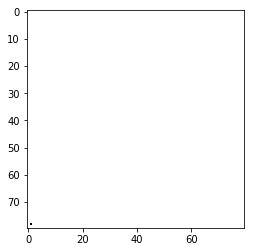

In [48]:
################################################################
# Example 4: fixed threshold, sparse lateral connectivity, Symmetric-STDP
################################################################

'''
TODO:
1) Add inhibitory neurons
2) Add homeostatic synaptic plasticity
3) Get system from overdrive to balanced input-driven
3) Make video of window-rate
'''

start_scope()
prefs.codegen.target = "numpy"

N_NEURON = img1.shape[0] * img1.shape[1]
print('Number of neurons is', N_NEURON)

RUN_TIME = 500*ms

# Fixed threshold neurons
LIF_V_TAU = 10*ms
LIF_V_0 = 0.0*mV
LIF_T_0 = 50.0*mV

# Sync input voltage, so that for average threshold the leak would balance out the input
INPUT_FREQ_0 = 10*Hz
INPUT_FREQ_MAX = 100*Hz
INPUT_FREQ_AVG = INPUT_FREQ_0 + INPUT_FREQ_MAX / 2
INPUT_DV_PER_SPIKE = 0.25 * LIF_T_0 / LIF_V_TAU / INPUT_FREQ_AVG
print("Typical threshold is", LIF_T_AVG, ", voltage increase per spike is", INPUT_DV_PER_SPIKE)

# LIF neurons will be sparsely connected laterally
W_CONN_P_LATERAL = 0.01
W_0 = 1.0
W_MAX = 2.0
DV_SPIKE = LIF_T_0 / (0.1 * N_NEURON * W_CONN_P_LATERAL)

print("typical number of presynaptic neurons", N_NEURON * W_CONN_P_LATERAL)
print("typical potential change per lateral spike", DV_SPIKE)

# STDP
DW_STDP_FORW_MAX = 0.01     # Maximal change of weight due to causal spike sequence
DW_STDP_BACK_MAX = -0.01    # Maximal change of weight due to anti-causal spike sequence
DW_STDP_PRE_TAU = 20*ms     # STDP presynaptic spike trace timescale
DW_STDP_POST_TAU = 20*ms    # STDP postsynaptic spike trace timescale

# Basic LIF
eqs_neu = '''
dv/dt = (LIF_V_0 - v) / LIF_V_TAU : volt
'''

# Two auxiliary variables track decaying trace of
# presynaptic and postsynaptic spikes
syn_eq = '''
w : 1
dzpre/dt = -zpre/DW_STDP_PRE_TAU : 1 (event-driven)
dzpost/dt = -zpost/DW_STDP_POST_TAU : 1 (event-driven)
'''
# 

# On spike increase decaying variable by fixed amount
# Increase weight by the value of the decaying variable
# from the other side of the synapse
syn_pre_eq = '''
zpre += 1
w = clip(w + DW_STDP_BACK_MAX * zpost, 0, W_MAX)
v_post += DV_SPIKE * w
'''
# w + DW_STDP_BACK_MAX * zpost  

syn_post_eq = '''
zpost += 1
w = clip(w + DW_STDP_FORW_MAX * zpre, 0, W_MAX)
'''
# w + DW_STDP_FORW_MAX * zpre

# Connect Input and LIF one-to-one
P_img1 = PoissonGroup(N_NEURON, INPUT_FREQ_0 + INPUT_FREQ_MAX * np.ndarray.flatten(img1))
G = NeuronGroup(N_NEURON, eqs_neu, threshold='v > LIF_T_0', reset='v = LIF_V_0', method='exact')
S = Synapses(P_img1, G, on_pre='v_post += INPUT_DV_PER_SPIKE')
S.connect(j='i')

# Connect LIF neurons to each other sparsely
S_LAT = Synapses(G, G, syn_eq, on_pre=syn_pre_eq, on_post=syn_post_eq)
S_LAT.connect(p=W_CONN_P_LATERAL)
S_LAT.w = 'W_0'

# NOTE: As opposed to Example1, here we monitor the spiking of the LIF neurons
spikemon = SpikeMonitor(G)

run(RUN_TIME)

print("Min weight after training is", np.min(np.array(S_LAT.w)))
print("Max weight after training is", np.max(np.array(S_LAT.w)))
print("Average weight after training is", np.average(np.array(S_LAT.w)))

(15787398,)
0.00914648421055
0.0125061069427
0.0124999295821


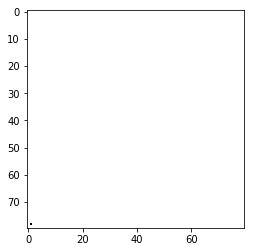

In [53]:
print(np.array(spikemon.t).shape)

# Compute observed spike rate by counting how many times each neuron spiked
rate = np.zeros(N_NEURON)
for i in np.array(spikemon.i):
    rate[i] += 1
rate /= np.linalg.norm(rate)

print(np.min(rate))
print(np.max(rate))
print(np.average(rate))

# Plot observed spike rate 
plt.figure()
plt.imshow(rate.reshape(img1.shape), cmap='gray')
plt.show()

Number of neurons is 6400
Threshold growth per spike is 5. mV
Input weight is 83.33333333 mV


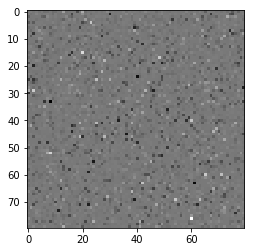

In [22]:
################################################################
# Example 5: Lets have both HP and Lateral Connectivity
################################################################

start_scope()

N_NEURON = img1.shape[0] * img1.shape[1]
print('Number of neurons is', N_NEURON)

RUN_TIME = 1000*ms

LIF_LEAK_TIMESCALE = 10*ms
LIF_POTENTIAL_RESTING = 0.0*mV

LIF_HP_TIMESCALE = 100*ms
LIF_HP_THRESHOLD_RESTING = 1.0*mV
LIF_HP_THRESHOLD_TYPICAL = 50.0*mV
LIF_HP_THRESHOLD_GROWTH = LIF_HP_THRESHOLD_TYPICAL * LIF_LEAK_TIMESCALE / LIF_HP_TIMESCALE
print("Threshold growth per spike is", LIF_HP_THRESHOLD_GROWTH)

INPUT_FREQ_BACKGROUND = 10*Hz
INPUT_FREQ_SENSITIITY = 100*Hz
INPUT_FREQ_TYPICAL = INPUT_FREQ_BACKGROUND + INPUT_FREQ_SENSITIITY / 2
INPUT_WEIGHT = LIF_HP_THRESHOLD_TYPICAL / LIF_LEAK_TIMESCALE / INPUT_FREQ_TYPICAL
print("Input weight is", INPUT_WEIGHT)

LATERAL_CONN_PROBABILITY = 0.01

eqs_neu = '''
dv/dt = (LIF_POTENTIAL_RESTING - v) / LIF_LEAK_TIMESCALE : volt
dT/dt = (LIF_HP_THRESHOLD_RESTING - T) / LIF_HP_TIMESCALE : volt
'''

reset = '''
v = LIF_POTENTIAL_RESTING
T += LIF_HP_THRESHOLD_GROWTH
'''

P_img1 = PoissonGroup(N_NEURON, INPUT_FREQ_BACKGROUND + INPUT_FREQ_SENSITIITY * np.ndarray.flatten(img1))
G = NeuronGroup(N_NEURON, eqs_neu, threshold='v > T', reset=reset)
S_INP = Synapses(P_img1, G, on_pre='v_post += INPUT_WEIGHT')
S_INP.connect(j='i')

S_LAT = Synapses(G, G, on_pre='v_post += INPUT_WEIGHT')
S_LAT.connect(p=LATERAL_CONN_PROBABILITY)

run(RUN_TIME)
    
plt.figure()
plt.imshow(np.array(G.T).reshape(img1.shape), cmap='gray')
plt.show()